# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

## Setup

### Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### User parameters

In [2]:
user_params = {
    'output_dir'  : './results',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
}

In [3]:
ls

data/  DBTL1Recs4David.ipynb  results/


### Useful functions

In [4]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

In [5]:
def plot_titers(df_prod, df_control_stat, product='Isoprenol'):
    "Plots isprenols titers as well as CV"
    "NOT REALLY WORKING AS OF NOW"
    
    ## Create fig
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.set_style("white")
    
    ## Plot production in salmon color
    g = sns.scatterplot(data=df_prod, 
                      x='Strain',
                      y=product,
                      color='salmon',
                  )
    ## Surround controls with black edge 
    plt.scatter(np.ones(df_control_stat['Isoprenol'].shape), df_control_stat[product],
                marker='o', color="None", edgecolor='k', label='Control'
                )
    ## Label axes
    g.set_xticklabels(df_prod['Strain'].unique(), fontsize=10, rotation = 90)
    ax.set_ylabel(product+" [uM]", fontsize=10, color='salmon')
    ax.set_xlabel("Strains", fontsize=10)
    ax2 = plt.twinx()
    g2 = sns.scatterplot(data=df_prod,
                    x='Strain',
                    y='CV[%]', 
                    color='gray', marker='o',
                        ax=ax2)
    plt.scatter([1], df_control_stat['CV[%]'].iloc[0],
                marker='o', color="None",  edgecolor='k', label='Control'
                )
    ax2.set_ylabel("CV[%]", fontsize=10, color='gray')
    sns.despine(left=True, bottom=True)
    ax.legend()

    fig.savefig(
        f"{user_params['output_dir']}/titer_cv.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

In [6]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df_targets.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [7]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

In [8]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):
    "Choose recommended double and triple targets for CRISPRi knockdown"

    targets_list = list(df_targets['Target'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = tuple(sorted(random.sample(
            targets_list, counts=weights, k=size
        ))) # random sampling without replacement
        # new_target = sorted(random.choices(targets_list, weights=weights, k=size))
        # Check that the targets are not the same (sample function could provide repeated targets)
        # and if the combination was already chosen
        if len(set(new_target)) == size and new_target not in targets:
            targets.add(new_target)
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [9]:
 def plot_double_targets(targets_double, df_targets):
    "Plot double targets chosen with the function above"    
        
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Target'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [10]:
 def plot_triple_targets(targets_triple, df_targets):
    "Plot triple targets chosen with the function above"    
   
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Target']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

## Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [11]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'hgmartin'


We try connecting to the server with our login and password:

In [12]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for hgmartin:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [13]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

100%|██████████| 1182270/1182270 [01:02<00:00, 19056.11it/s]


There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [14]:
df['Protocol'].unique()

array(['Biolector', 'GC-FID', 'Global Proteomics'], dtype=object)

## Preprocess and inspect data

### Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [15]:
df['Protocol']=='Biolector'

0           True
1           True
2           True
3           True
4           True
           ...  
1182265    False
1182266    False
1182267    False
1182268    False
1182269    False
Name: Protocol, Length: 1182270, dtype: bool

In [16]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [17]:
df2.shape

(1033140, 15)

Let's just keep the basic data types:

In [18]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [19]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(420,
 array(['BL1A2_IY1586', 'BL1A3_IY1587', 'BL1A4_IY1588', 'BL1A5_IY1589',
        'BL1A6_IY1590', 'BL1A7_IY1591', 'BL1A8_IY1592', 'BL1B2_IY1586',
        'BL1B3_IY1587', 'BL1B4_IY1588', 'BL1B5_IY1589', 'BL1B6_IY1590',
        'BL1B7_IY1591', 'BL1B8_IY1592', 'BL1C2_IY1586', 'BL1C3_IY1587',
        'BL1C4_IY1588', 'BL1C5_IY1589', 'BL1C6_IY1590', 'BL1C7_IY1591',
        'BL1C8_IY1592', 'BL1D1_IY1593', 'BL1D2_IY1594', 'BL1D3_IY1595',
        'BL1D4_IY1596', 'BL1D5_IY1597', 'BL1D6_IY1452_pIY1081',
        '**BL1D7_IY1655', '**BL1D8_IY1656', '**BL1E1_IY1593',
        '**BL1E2_IY1594', '**BL1E3_IY1595', 'BL1E4_IY1596', 'BL1E5_IY1597',
        'BL1E6_IY1452_pIY1081', 'BL1E7_IY1655', 'BL1E8_IY1656',
        'BL1F1_IY1593', 'BL1F2_IY1594', 'BL1F3_IY1595', 'BL1F4_IY1596',
        'BL1F5_IY1597', 'BL1F6_IY1452_pIY1081', 'BL1F7_IY1655',
        'BL1F8_IY1656', 'BL2A2_IY1452_pIY1079', 'BL2A3_IY1452_pIY1080',
        'BL2A4_IY1657', 'BL2A5_IY1658', 'BL2A6_IY1659', 'BL2A7_IY1660',
        'BL2A8_I

In [20]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(420,
 array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
        'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
        'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
        'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
        'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
        'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
        'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
        'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
        'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
        'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
        'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
        'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
        'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
        'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
        'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
        'PP_0338-R1', 

In [21]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

In [22]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [23]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

In [24]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02
...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05


In [25]:
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588


### Get strain names

Next we stores the Strain names (from the line description) in a separate column for later use:

In [26]:
df2["Strain"] = create_strain_names(df2)

In [27]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,IY1586
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,IY1587
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,IY1588
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,IY1589
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,IY1590
...,...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06,IY2022
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05,IY2022
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05,IY2019
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05,IY2019


In [28]:
(df2['Strain'].unique())

array(['IY1586', 'IY1587', 'IY1588', 'IY1589', 'IY1590', 'IY1591',
       'IY1592', 'IY1593', 'IY1594', 'IY1595', 'IY1596', 'IY1597',
       'IY1452', 'IY1655', 'IY1656', 'IY1657', 'IY1658', 'IY1659',
       'IY1660', 'IY1661', 'IY1662', 'IY1663', 'IY1664', 'IY1665',
       'IY1666', 'IY1667', 'IY1668', 'IY1669', 'IY1670', 'IY1671',
       'IY1672', 'IY1673', 'IY1674', 'IY1675', 'IY1676', 'IY1677',
       'IY1678', 'IY1679', 'IY1680', 'IY1682', 'IY1683', 'IY1684',
       'IY1685', 'IY1686', 'IY1687', 'IY1688', 'IY1689', 'IY1690',
       'IY1681', 'IY2020', 'IY2021', 'IY2023', 'IY2024', 'IY2054',
       'IY2027', 'IY2028', 'IY2031', 'IY2033', 'IY2034', 'IY2055',
       'IY2035', 'IY2056', 'IY2036', 'IY2037', 'IY2038', 'IY2057',
       'IY2058', 'IY2039', 'IY2040', 'IY2041', 'IY2042', 'IY2043',
       'IY2044', 'IY2045', 'IY2046', 'IY2047', 'IY2048', 'IY2186',
       'IY2187', 'IY2188', 'IY2189', 'IY2190', 'IY2237', 'IY2191',
       'IY2238', 'IY2192', 'IY2239', 'IY2193', 'IY2195', 'IY21

#### Define control strains

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [29]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)

In [30]:
df2.loc[df2['Control']==True,:]

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control
149532,Control-R1,BL1A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.660055e+02,NT,True
149533,Control-R2,BL1B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.728256e+02,NT,True
149534,Control-R3,BL1C1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.541087e+02,NT,True
149535,Control-R4,BL2A1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.425143e+02,NT,True
149536,Control-R5,BL2B1_NT,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.046448e+02,NT,True
...,...,...,...,...,...,...,...,...
1181817,Control-R18,BL6C1_NT,Global Proteomics,sp|Q9FD71|HMGCS_ENTFL,Hydroxymethylglutaryl-CoA synthase,8.302083e+07,NT,True
1182042,Control-R15,BL5C1_NT,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.117643e+06,NT,True
1182043,Control-R16,BL6A1_NT,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.821115e+06,NT,True
1182044,Control-R17,BL6B1_NT,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.755651e+06,NT,True


This is the control strain:

In [31]:
df2.loc[df2['Control']==True,:]['Strain'].unique()

array(['NT'], dtype=object)

In [32]:
control_strain = df2.loc[df2['Control']==True,:]['Strain'].unique()[0]

In [33]:
control_strain

'NT'

### Check negative values

Check if there are negative values for measurements (a big no no for concentrations and protein counts):

In [34]:
len(df2[df2['Value'] < 0])

0

It seems we are good.

### Check replicates

Let's check how many replicates we have for our data:

In [35]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [36]:
df2[df2['Protocol']=='GC-FID']['Line Name'].unique()

array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
       'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
       'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
       'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
       'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
       'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
       'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
       'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
       'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
       'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
       'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
       'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
       'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
       'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
       'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
       'PP_0338-R1', 'PP_3394-R1', 'PP_1607

We seem to have triplicates for isoprenol measurements

In [37]:
df2[df2['Protocol']=='Global Proteomics']['Line Name'].unique()

array(['Control-R1', 'Control-R2', 'Control-R3', 'Control-R4',
       'Control-R5', 'Control-R6', 'Control-R7', 'PP_0338-R1',
       'PP_0338-R2', 'PP_0338-R3', 'PP_0362-R1', 'PP_0362-R2',
       'PP_0362-R3', 'PP_0368-R1', 'PP_0368-R2', 'PP_0368-R3',
       'PP_0437-R1', 'PP_0437-R2', 'PP_0437-R3', 'PP_0582-R1',
       'PP_0582-R2', 'PP_0582-R3', 'PP_0774-R1', 'PP_0774-R2',
       'PP_0774-R3', 'PP_1157-R1', 'PP_1157-R2', 'PP_1157-R3',
       'PP_1394-R1', 'PP_1444-R1', 'PP_1444-R2', 'PP_1444-R3',
       'PP_1607_NT1-R1', 'PP_1607_NT1-R2', 'PP_1607_NT1-R3',
       'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT1_xylS_Pm-R2',
       'PP_1607_NT1_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT2-R2',
       'PP_1607_NT2-R3', 'PP_1607_NT2_xylS_Pm-R1',
       'PP_1607_NT2_xylS_Pm-R2', 'PP_1607_NT2_xylS_Pm-R3',
       'PP_1607_NT3-R1', 'PP_1607_NT3-R2', 'PP_1607_NT3-R3',
       'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT3_xylS_Pm-R2',
       'PP_1607_NT3_xylS_Pm-R3', 'PP_1607_NT4-R1', 'PP_1607_NT4-R2',
       '

And we have triplicates for proteomics measurements, as well. 

### Protein data

Let's get the protein data into proper format for later use:

#### Bring out Uniprot names

Filter everything out from the formal type except uniprot name ('sp|Q9Z408|CSD_PSEPK Csda' --> 'Q9Z408'):

In [38]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)

In [39]:
get_Uniprot('sp|Q9Z408|CSD_PSEPK Csda')  # filters name only if protein

'Q9Z408'

In [40]:
get_Uniprot('cid:12988')                 # Doesn't change anything otherwise

'cid:12988'

In [41]:
df2['Formal Type'] =  df2['Formal Type'].apply(get_Uniprot)

In [42]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,IY1586,False
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,IY1587,False
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,IY1588,False
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,IY1589,False
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,IY1590,False
...,...,...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q9Z408,Probable cysteine desulfurase,1.051687e+06,IY2022,False
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q9Z408,Probable cysteine desulfurase,9.921411e+05,IY2022,False
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q9Z408,Probable cysteine desulfurase,5.949145e+05,IY2019,False
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q9Z408,Probable cysteine desulfurase,3.865737e+05,IY2019,False


#### Limit protein data to target genes

Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [43]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])

In [44]:
ProtMapping_df

,CRISPRi target gene,UNIPROT ID
0,PP_1607_NT2,Q88MG4
1,PP_1607_NT3,Q88MG4
2,PP_1607_NT4,Q88MG4
3,PP_4549,Q88EB7
4,PP_4550,Q88EB6
...,...,...
126,PP_4186,Q88FB2
127,PP_1023,Q88P30
128,PP_5128,Q88CQ2
129,PP_2095,Q88L40


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607', **PLEASE CHECK THIS IS OK!!**):

In [45]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])

Find all target genes/proteins from this mapping:

In [46]:
targets = ProtMapping_df['UNIPROT ID'].unique().tolist()

In [47]:
targets[0:10]

['Q88MG4',
 'Q88EB7',
 'Q88EB6',
 'Q88QW6',
 'Q88L02',
 'Q88PS4',
 'Q88QX2',
 'Q88QQ1',
 'Q88JR0',
 'Q88GH9']

In [48]:
df2.loc[df2['Formal Type'].isin(targets),'Formal Type']

150702     P0A126
150703     P0A126
150704     P0A126
150705     P0A126
150706     P0A126
            ...  
1173145    Q88RM6
1173146    Q88RM6
1173147    Q88RM6
1173148    Q88RM6
1173149    Q88RM6
Name: Formal Type, Length: 40968, dtype: object

In [49]:
df2[(df2['Formal Type'].isin(targets)) & (df2['Protocol']=='Global Proteomics')]

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control
150702,Control-R1,BL1A1_NT,Global Proteomics,P0A126,Integration host factor subunit alpha,4201002.90,NT,True
150703,Control-R2,BL1B1_NT,Global Proteomics,P0A126,Integration host factor subunit alpha,4517773.00,NT,True
150704,Control-R3,BL1C1_NT,Global Proteomics,P0A126,Integration host factor subunit alpha,3999560.28,NT,True
150705,Control-R4,BL2A1_NT,Global Proteomics,P0A126,Integration host factor subunit alpha,3858903.76,NT,True
150706,Control-R5,BL2B1_NT,Global Proteomics,P0A126,Integration host factor subunit alpha,3800910.30,NT,True
...,...,...,...,...,...,...,...,...
1173145,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,1677449.00,IY2022,False
1173146,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,1181200.00,IY2022,False
1173147,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,823529.94,IY2019,False
1173148,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,817266.74,IY2019,False


In [50]:
df2[(~df2['Formal Type'].isin(targets)) & (df2['Protocol']=='Global Proteomics')].index

Int64Index([ 149550,  149551,  149552,  149553,  149554,  149555,  149556,
             149557,  149558,  149559,
            ...
            1182260, 1182261, 1182262, 1182263, 1182264, 1182265, 1182266,
            1182267, 1182268, 1182269],
           dtype='int64', length=991752)

Drop the rows that are not in targets from the proteomics protocol:

In [51]:
df2 = df2.drop(index=df2[(~df2['Formal Type'].isin(targets)) & (df2['Protocol']=='Global Proteomics')].index)

In [52]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,IY1586,False
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,IY1587,False
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,IY1588,False
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,IY1589,False
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,IY1590,False
...,...,...,...,...,...,...,...,...
1173145,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,1.677449e+06,IY2022,False
1173146,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,1.181200e+06,IY2022,False
1173147,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,8.235299e+05,IY2019,False
1173148,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,8.172667e+05,IY2019,False


In [53]:
'Q88RM6' in targets

True

#### Change names from Uniprot to PP_ names

Use the mapping again to change names from Uniprot to PPxx names:

In [54]:
ProtMapping_df

,CRISPRi target gene,UNIPROT ID
0,PP_1607,Q88MG4
1,PP_1607,Q88MG4
2,PP_1607,Q88MG4
3,PP_4549,Q88EB7
4,PP_4550,Q88EB6
...,...,...
126,PP_4186,Q88FB2
127,PP_1023,Q88P30
128,PP_5128,Q88CQ2
129,PP_2095,Q88L40


In [55]:
len(ProtMapping_df["CRISPRi target gene"].unique())

123

In [56]:
len(ProtMapping_df["UNIPROT ID"].unique())

120

Create a protein mapping dictionary that translates from Uniprot to PP names:
(**NOTICE THERE IS NOT A ONE TO ONE CORRESPONDENCE, SO WE NEED TO DISCUSS THIS**)

In [57]:
proteinMap = {}
for index in ProtMapping_df.index:
    proteinMap[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

In [58]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,IY1586,False
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,IY1587,False
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,IY1588,False
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,IY1589,False
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,IY1590,False
...,...,...,...,...,...,...,...,...
1173145,PP_5416-R2,BL10B5_IY2022,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,1.677449e+06,IY2022,False
1173146,PP_5416-R3,BL10C5_IY2022,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,1.181200e+06,IY2022,False
1173147,PP_5420-R1,BL10A4_IY2019,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,8.235299e+05,IY2019,False
1173148,PP_5420-R2,BL10B4_IY2019,Global Proteomics,Q88RM6,Cytochrome c oxidase subunit 2,8.172667e+05,IY2019,False


And do the translation:

In [59]:
ProteomicsInd = df2['Protocol']=='Global Proteomics'

df2.loc[ProteomicsInd,'Formal Type'] = df2.loc[ProteomicsInd,'Formal Type'].apply(lambda x: proteinMap[x])

In [60]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02,IY1586,False
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02,IY1587,False
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02,IY1588,False
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02,IY1589,False
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02,IY1590,False
...,...,...,...,...,...,...,...,...
1173145,PP_5416-R2,BL10B5_IY2022,Global Proteomics,PP_0103,Cytochrome c oxidase subunit 2,1.677449e+06,IY2022,False
1173146,PP_5416-R3,BL10C5_IY2022,Global Proteomics,PP_0103,Cytochrome c oxidase subunit 2,1.181200e+06,IY2022,False
1173147,PP_5420-R1,BL10A4_IY2019,Global Proteomics,PP_0103,Cytochrome c oxidase subunit 2,8.235299e+05,IY2019,False
1173148,PP_5420-R2,BL10B4_IY2019,Global Proteomics,PP_0103,Cytochrome c oxidase subunit 2,8.172667e+05,IY2019,False


#### Add target gene

Add now a column with the target gene for each strain:

In [61]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)

In [62]:
get_target_gene('PP_4549-R1')

'PP_4549'

In [63]:
df2['Target']=df2['Line Name'].apply(get_target_gene)

In [64]:
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Strain,Control,Target
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,IY1586,False,PP_4549
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,IY1587,False,PP_4550
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,IY1588,False,PP_0368
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,IY1589,False,PP_2136
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,IY1590,False,PP_0774


## Statistical analysis

### Pivot dataframe to table

First, let's pivot the data into an easier format to work with:

In [65]:
df_targets = df2.pivot_table(
    index="Strain", columns=["Formal Type"], values="Value", aggfunc=np.mean    #Using mean here instead of sum
)

In [66]:
df_targets

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,1.124118e+07,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,6.638675e+06,3.309500e+07,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111
IY1586,4.941056e+06,NaN,1.236235e+07,9.721919e+06,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,3.389466e+06,3.538221e+07,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833
IY1587,3.383160e+06,NaN,6.041816e+06,9.352343e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,2.688070e+06,4.170485e+07,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567
IY1588,3.782190e+06,NaN,1.541983e+07,9.795028e+06,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,3.791270e+06,4.037166e+07,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800
IY1589,5.161205e+06,NaN,6.916297e+06,1.067935e+07,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,2.764658e+06,3.808640e+07,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IY2237,2.551562e+06,27225.933333,5.617526e+06,6.300809e+06,177208.746667,4.531242e+07,4.233804e+06,334483.353333,5.641511e+05,6806.483333,...,2.228676e+06,2.260773e+07,813603.970000,70950.503333,2.034283e+06,4.045274e+06,6.612702e+06,2.121695e+07,2.770417e+05,198.964367
IY2238,3.479561e+06,40485.960000,8.943537e+06,5.933978e+06,90210.166667,4.384645e+07,3.470908e+06,259724.090000,4.674478e+05,10121.490000,...,1.669236e+06,2.367315e+07,675847.070000,77744.156667,1.505822e+06,4.150746e+06,5.089367e+06,1.827777e+07,2.024298e+04,160.748000
IY2239,2.883891e+06,16973.733333,6.771840e+06,5.520682e+06,170363.866667,3.842493e+07,3.989654e+06,341517.433333,4.326523e+05,4243.433333,...,1.596786e+06,2.195752e+07,329903.733333,97011.533333,2.739738e+06,3.983225e+06,5.140160e+06,1.876271e+07,8.486867e+03,197.783400


Change the compound id (cid) into its common name:

In [67]:
df_targets.rename(columns={'cid:12988': 'Isoprenol mean'}, inplace=True)

In [68]:
df_targets

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,1.124118e+07,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,6.638675e+06,3.309500e+07,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111
IY1586,4.941056e+06,NaN,1.236235e+07,9.721919e+06,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,3.389466e+06,3.538221e+07,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833
IY1587,3.383160e+06,NaN,6.041816e+06,9.352343e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,2.688070e+06,4.170485e+07,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567
IY1588,3.782190e+06,NaN,1.541983e+07,9.795028e+06,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,3.791270e+06,4.037166e+07,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800
IY1589,5.161205e+06,NaN,6.916297e+06,1.067935e+07,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,2.764658e+06,3.808640e+07,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IY2237,2.551562e+06,27225.933333,5.617526e+06,6.300809e+06,177208.746667,4.531242e+07,4.233804e+06,334483.353333,5.641511e+05,6806.483333,...,2.228676e+06,2.260773e+07,813603.970000,70950.503333,2.034283e+06,4.045274e+06,6.612702e+06,2.121695e+07,2.770417e+05,198.964367
IY2238,3.479561e+06,40485.960000,8.943537e+06,5.933978e+06,90210.166667,4.384645e+07,3.470908e+06,259724.090000,4.674478e+05,10121.490000,...,1.669236e+06,2.367315e+07,675847.070000,77744.156667,1.505822e+06,4.150746e+06,5.089367e+06,1.827777e+07,2.024298e+04,160.748000
IY2239,2.883891e+06,16973.733333,6.771840e+06,5.520682e+06,170363.866667,3.842493e+07,3.989654e+06,341517.433333,4.326523e+05,4243.433333,...,1.596786e+06,2.195752e+07,329903.733333,97011.533333,2.739738e+06,3.983225e+06,5.140160e+06,1.876271e+07,8.486867e+03,197.783400


Add let's now add the target genes to this table:

In [69]:
TargetMap = df2[["Strain","Target"]].drop_duplicates().set_index("Strain")

In [70]:
TargetMap

,Target
Strain,
IY1586,PP_4549
IY1587,PP_4550
IY1588,PP_0368
IY1589,PP_2136
IY1590,PP_0774
...,...
IY2029,PP_4123
IY2032,PP_4128
IY2019,PP_5420


In [71]:
df_targets.loc[TargetMap.index,"Target"] = TargetMap["Target"]

In [72]:
df_targets

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,1.124118e+07,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,3.309500e+07,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111,PP_1607
IY1586,4.941056e+06,NaN,1.236235e+07,9.721919e+06,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,3.538221e+07,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833,PP_4549
IY1587,3.383160e+06,NaN,6.041816e+06,9.352343e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,4.170485e+07,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567,PP_4550
IY1588,3.782190e+06,NaN,1.541983e+07,9.795028e+06,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,4.037166e+07,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800,PP_0368
IY1589,5.161205e+06,NaN,6.916297e+06,1.067935e+07,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,3.808640e+07,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900,PP_2136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IY2237,2.551562e+06,27225.933333,5.617526e+06,6.300809e+06,177208.746667,4.531242e+07,4.233804e+06,334483.353333,5.641511e+05,6806.483333,...,2.260773e+07,813603.970000,70950.503333,2.034283e+06,4.045274e+06,6.612702e+06,2.121695e+07,2.770417e+05,198.964367,PP_1023
IY2238,3.479561e+06,40485.960000,8.943537e+06,5.933978e+06,90210.166667,4.384645e+07,3.470908e+06,259724.090000,4.674478e+05,10121.490000,...,2.367315e+07,675847.070000,77744.156667,1.505822e+06,4.150746e+06,5.089367e+06,1.827777e+07,2.024298e+04,160.748000,PP_5128
IY2239,2.883891e+06,16973.733333,6.771840e+06,5.520682e+06,170363.866667,3.842493e+07,3.989654e+06,341517.433333,4.326523e+05,4243.433333,...,2.195752e+07,329903.733333,97011.533333,2.739738e+06,3.983225e+06,5.140160e+06,1.876271e+07,8.486867e+03,197.783400,PP_2095


Some target genes are note present in the proteomics data:

In [73]:
for gene in df_targets["Target"]:
    if gene not in df_targets.columns:
        print(gene)

PP_0362
PP_2589
PP_3744
PP_3394
PP_3355
PP_3282
PP_1157
PP_1394
PP_3280
PP_4737
PP_5420
PP_0806
PP_4128
PP_4188
PP_4043
PP_0104
PP_0105
PP_0106
PP_0813
PP_0815
PP_4161
PP_4160
PP_4159
PP_0277
Control


### Proteomics data

Now we can add the statistical data from the proteomics data (mean, std, first and third quantile):

In [74]:
df_targets = find_library_stats(df_targets)

/tmp/ipykernel_1296431/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1296431/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1296431/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1296431/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None


Data for these 25 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4188', 'PP_4043', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0813', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'Control']


In [75]:
df_targets

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,1.124118e+07,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,3.309500e+07,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111,PP_1607
IY1586,4.941056e+06,NaN,1.236235e+07,9.721919e+06,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,3.538221e+07,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833,PP_4549
IY1587,3.383160e+06,NaN,6.041816e+06,9.352343e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,4.170485e+07,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567,PP_4550
IY1588,3.782190e+06,NaN,1.541983e+07,9.795028e+06,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,4.037166e+07,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800,PP_0368
IY1589,5.161205e+06,NaN,6.916297e+06,1.067935e+07,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,3.808640e+07,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900,PP_2136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,4.190752e+06,17237.230000,9.065235e+06,9.133443e+06,231729.880000,6.404960e+07,7.475888e+06,414110.655556,7.558040e+05,4309.307500,...,3.496566e+07,837986.602778,178156.592222,3.109214e+06,5.058710e+06,8.390255e+06,2.702211e+07,1.193798e+06,254.648694,Control
Library_mean,3.414433e+06,83293.375614,9.349293e+06,7.547084e+06,185201.354357,5.084225e+07,5.920965e+06,295036.870542,6.907668e+05,19054.325119,...,2.813794e+07,600862.612507,171669.659934,2.442659e+06,4.516804e+06,6.909082e+06,2.414633e+07,3.813389e+05,NaN,NaN
Library_std,1.002450e+06,205309.771335,4.764965e+06,2.921855e+06,143476.518113,1.375086e+07,3.444215e+06,132166.182716,2.791358e+05,31765.947948,...,7.673214e+06,249896.728229,110649.467870,1.068624e+06,9.093907e+05,1.327981e+06,5.414382e+06,4.036474e+05,NaN,NaN


### Production data

We now find the coefficient of variation for the isoprenol data:

In [76]:
df_isoprenol             = df2[df2['Measurement Type']=='3-METHYL-3-BUTEN-1-OL']
df_isoprenol             = df_isoprenol.drop(columns=['Line Name', 'Line Description', 'Measurement Type', 'Protocol','Control'])
stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
stats_isoprenol.rename(columns={'Value': 'mean'}, inplace=True)
stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()
stats_isoprenol['CV[%]'] = 100* stats_isoprenol['std'] / stats_isoprenol['mean']
stats_isoprenol = stats_isoprenol.sort_values('CV[%]', ascending=False)
stats_isoprenol.head()

/tmp/ipykernel_1296431/688815194.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
/tmp/ipykernel_1296431/688815194.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()


,mean,std,CV[%]
Strain,,,
IY2192,15.849800,27.452659,173.205081
IY1671,100.588117,110.470009,109.824115
IY2025,27.581113,23.906693,86.677767
IY2195,63.463733,39.644337,62.467704
IY1597,275.054650,93.993453,34.172646


Let's now add the statistic to the main dataframe:

In [77]:
product = 'Isoprenol'
df_isoprenol.rename(columns={'Value': product}, inplace=True)
df_isoprenol = df_isoprenol.sort_values(product, ascending=False)
df_isoprenol['CV[%]'] = None

strains = [strain for strain in stats_isoprenol.index.unique()]
for strain in strains:
    index = df_isoprenol[df_isoprenol['Strain']==strain].index
    cv_value = stats_isoprenol[stats_isoprenol.index==strain]['CV[%]'].values
    df_isoprenol.loc[index, 'CV[%]'] = np.ones(len(index))*cv_value

df_isoprenol.drop(columns='Formal Type', inplace=True)
df_isoprenol.set_index("Strain", inplace=True)

In [78]:
df_isoprenol.loc["IY1452"]

,Isoprenol,Target,CV[%]
Strain,,,
IY1452,374.7397,PP_1607,20.218016
IY1452,350.1727,PP_1607,20.218016
IY1452,327.9539,PP_1607,20.218016
IY1452,325.2797,PP_1607,20.218016
IY1452,285.8704,PP_1607,20.218016
IY1452,269.9460,PP_1607,20.218016
IY1452,247.7752,PP_1607,20.218016
IY1452,215.6081,PP_1607,20.218016
IY1452,210.9813,PP_1607,20.218016


In [79]:
df_isoprenol

,Isoprenol,Target,CV[%]
Strain,,,
IY2020,618.3056,PP_5419,5.359461
IY1688,603.9709,PP_0528,2.279287
IY1688,590.6272,PP_0528,2.279287
IY2020,587.8620,PP_5419,5.359461
IY1688,577.0506,PP_0528,2.279287
...,...,...,...
IY2192,0.0000,PP_5064,173.205081
IY1671,0.0000,PP_4679,109.824115
IY1673,0.0000,PP_1777,NaN


Stats for control strain:

In [80]:
df_control_stat = df_isoprenol.loc[control_strain]

### Merging all information into a single dataframe

Add the CV information (isoprenol mean is already there)

In [81]:
df_targets.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]

In [82]:
df_targets

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target,CV[%]
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,1.124118e+07,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111,PP_1607,20.218016
IY1586,4.941056e+06,NaN,1.236235e+07,9.721919e+06,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833,PP_4549,1.258797
IY1587,3.383160e+06,NaN,6.041816e+06,9.352343e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567,PP_4550,8.410108
IY1588,3.782190e+06,NaN,1.541983e+07,9.795028e+06,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800,PP_0368,4.072284
IY1589,5.161205e+06,NaN,6.916297e+06,1.067935e+07,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900,PP_2136,0.74632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,4.190752e+06,17237.230000,9.065235e+06,9.133443e+06,231729.880000,6.404960e+07,7.475888e+06,414110.655556,7.558040e+05,4309.307500,...,837986.602778,178156.592222,3.109214e+06,5.058710e+06,8.390255e+06,2.702211e+07,1.193798e+06,254.648694,Control,11.693238
Library_mean,3.414433e+06,83293.375614,9.349293e+06,7.547084e+06,185201.354357,5.084225e+07,5.920965e+06,295036.870542,6.907668e+05,19054.325119,...,600862.612507,171669.659934,2.442659e+06,4.516804e+06,6.909082e+06,2.414633e+07,3.813389e+05,NaN,NaN,NaN
Library_std,1.002450e+06,205309.771335,4.764965e+06,2.921855e+06,143476.518113,1.375086e+07,3.444215e+06,132166.182716,2.791358e+05,31765.947948,...,249896.728229,110649.467870,1.068624e+06,9.093907e+05,1.327981e+06,5.414382e+06,4.036474e+05,NaN,NaN,NaN


## Data visualization

Visualize isoprenols production and coefficient of variation (**TO BE DONE!**):

In [83]:
#plot_titers(df_isoprenol, df_control_stat)

**THERE ARE SOME ERRORS IN THIS GRAPH THAT NEED TO BE FIXED!!!**

## Selecting target genes

**Criteria for downselection:**

- Transcription value for the **CRISPRi** targeted gene: 
    - Within the bottom 25th percentile of the library
    - More than 25% lower than the mean of the library


### Calculate ratios

We calculate the ratios of the target protein concentration to the control, library mean, Q1 and Q3 (eliminating the strain with the target gene):

In [84]:
df_targets = find_fold_changes(df_targets)

Data for these 25 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4188', 'PP_4043', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0813', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'Control']


In [85]:
df_targets

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5417,PP_5419,Isoprenol mean,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,1.124118e+07,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,2.881347e+07,8.183859e+05,289.814111,PP_1607,20.218016,0.962351,1.260467,1.626546,1.025424,0.892173
IY1586,4.941056e+06,NaN,1.236235e+07,9.721919e+06,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,3.218307e+07,4.716865e+05,302.681833,PP_4549,1.258797,0.055989,0.085443,0.114832,0.068155,-2.700526
IY1587,3.383160e+06,NaN,6.041816e+06,9.352343e+06,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,3.061075e+07,2.213753e+05,154.452567,PP_4550,8.410108,0.883285,0.341594,1.251369,0.354566,-0.309067
IY1588,3.782190e+06,NaN,1.541983e+07,9.795028e+06,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,3.083117e+07,1.164940e+06,355.020800,PP_0368,4.072284,0.037538,0.047396,0.070423,0.041274,-1.637626
IY1589,5.161205e+06,NaN,6.916297e+06,1.067935e+07,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,3.034837e+07,9.698603e+05,351.199900,PP_2136,0.74632,0.040121,0.043054,0.052783,0.037776,-2.583302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NT,4.190752e+06,17237.230000,9.065235e+06,9.133443e+06,231729.880000,6.404960e+07,7.475888e+06,414110.655556,7.558040e+05,4309.307500,...,2.702211e+07,1.193798e+06,254.648694,Control,11.693238,None,None,None,None,None
Library_mean,3.414433e+06,83293.375614,9.349293e+06,7.547084e+06,185201.354357,5.084225e+07,5.920965e+06,295036.870542,6.907668e+05,19054.325119,...,2.414633e+07,3.813389e+05,NaN,NaN,NaN,None,None,None,None,None
Library_std,1.002450e+06,205309.771335,4.764965e+06,2.921855e+06,143476.518113,1.375086e+07,3.444215e+06,132166.182716,2.791358e+05,31765.947948,...,5.414382e+06,4.036474e+05,NaN,NaN,NaN,None,None,None,None,None


### Downselect targets

Create new dataframe to ease filtering:

In [86]:
cols = [
    'Target',
    'Isoprenol mean','CV[%]',
    'Target:Control','Target:Library_mean',
    'Target:Library_Q1','Target:Library_Q3'
]
df_filtering = df_targets.loc[strains][cols]


In [87]:
df_filtering

Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY2192,PP_5064,15.849800,173.205081,0.725064,0.662723,1.162307,0.55705
IY1671,PP_4679,100.588117,109.824115,0.395498,0.685004,1.16743,0.493447
IY2025,PP_4119,27.581113,86.677767,0.092758,0.119652,0.187328,0.08702
IY2195,PP_1610,63.463733,62.467704,0.418672,0.592968,0.87684,0.449948
IY1597,PP_1607,275.054650,34.172646,None,None,None,None
...,...,...,...,...,...,...,...
IY1586,PP_4549,302.681833,1.258797,0.055989,0.085443,0.114832,0.068155
IY2047,PP_1317,228.187567,0.790181,0.009341,0.009184,0.014582,0.007451
IY1589,PP_2136,351.199900,0.74632,0.040121,0.043054,0.052783,0.037776


Select gene targets with a protein expression that is lower than 75% of the mean protein expresion and within the bottom 25th percentile of the library, while having a minimum production of 100: 

In [88]:
df_selection = df_filtering.loc[(
        (df_filtering['Target:Library_mean']<0.75) &
        (df_filtering['Target:Library_Q1']<1)
)
     & (df_filtering['Isoprenol mean']>100)
,:]

In [89]:
df_selection

Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY2057,PP_4187,215.706100,23.598608,0.384561,0.556083,0.786809,0.412976
IY2211,PP_4192,349.035467,20.285296,0.483296,0.5452,0.742546,0.424522
IY2216,PP_1755,172.138800,17.773086,0.047226,0.062057,0.093938,0.049562
IY1682,PP_2471,281.494767,17.505552,0.311721,0.412428,0.529113,0.336649
IY2225,PP_4185,172.424043,16.05754,0.26922,0.484682,0.663339,0.360442
...,...,...,...,...,...,...,...
IY2207,PP_0226,209.453243,1.802531,0.029683,0.037141,0.097742,0.024679
IY2026,PP_4120,242.994757,1.723609,0.008938,0.010626,0.014253,0.0081
IY1586,PP_4549,302.681833,1.258797,0.055989,0.085443,0.114832,0.068155


And here they are:

In [90]:
gene_targets= df_selection["Target"].tolist()
print(str(len(gene_targets))+ " gene targets:")
print(gene_targets)

61 gene targets:
['PP_4187', 'PP_4192', 'PP_1755', 'PP_2471', 'PP_4185', 'PP_4651', 'PP_1769', 'PP_4186', 'PP_2137', 'PP_1444', 'PP_4121', 'PP_1319', 'PP_0658', 'PP_0437', 'PP_0814', 'PP_0168', 'PP_4189', 'PP_4116', 'PP_0597', 'PP_4862', 'PP_4667', 'PP_1506', 'PP_4011', 'PP_2213', 'PP_0103', 'PP_3071', 'PP_2339', 'PP_1620', 'PP_0812', 'PP_0774', 'PP_4266', 'PP_0897', 'PP_0368', 'PP_5186', 'PP_4636', 'PP_3578', 'PP_1240', 'PP_4123', 'PP_3123', 'PP_2095', 'PP_3755', 'PP_5203', 'PP_1457', 'PP_4487', 'PP_0654', 'PP_1318', 'PP_4191', 'PP_5288', 'PP_0528', 'PP_4122', 'PP_2925', 'PP_0999', 'PP_0751', 'PP_3365', 'PP_3754', 'PP_2112', 'PP_0226', 'PP_4120', 'PP_4549', 'PP_1317', 'PP_2136']


While keeping the maximum production:

In [91]:
max(df_selection["Isoprenol mean"])

590.5495666666667

In [92]:
max(df_targets["Isoprenol mean"])

590.5495666666667

## Select double and triple combinations 

Here we specify how many instances (designs or recommendations) we want to create and how many replicates (change as desired): 

In [93]:
user_params['n_instances_double'] = 25
user_params['n_instances_triple'] = 25
user_params['n_replicates'] = 3 


In [94]:
df_selection.head()

Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY2057,PP_4187,215.706100,23.598608,0.384561,0.556083,0.786809,0.412976
IY2211,PP_4192,349.035467,20.285296,0.483296,0.5452,0.742546,0.424522
IY2216,PP_1755,172.138800,17.773086,0.047226,0.062057,0.093938,0.049562
IY1682,PP_2471,281.494767,17.505552,0.311721,0.412428,0.529113,0.336649
IY2225,PP_4185,172.424043,16.05754,0.26922,0.484682,0.663339,0.360442


And we make a new dataframe with just the data we need for this task:

In [95]:
df_targets2 = df_selection[["Target","Isoprenol mean"]]
df_targets2.columns.name=''

In [96]:
df_targets2

,Target,Isoprenol mean
Strain,,
IY2057,PP_4187,215.706100
IY2211,PP_4192,349.035467
IY2216,PP_1755,172.138800
IY1682,PP_2471,281.494767
IY2225,PP_4185,172.424043
...,...,...
IY2207,PP_0226,209.453243
IY2026,PP_4120,242.994757
IY1586,PP_4549,302.681833


To which we add the ratio of mean Isoprenol prodution to the production of the control strain:

In [97]:
control_production = df_targets.loc["NT",'Isoprenol mean']
df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production


/tmp/ipykernel_1296431/4093088892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production


In [98]:
df_targets2

,Target,Isoprenol mean,Ratio
Strain,,,
IY2057,PP_4187,215.706100,0.847073
IY2211,PP_4192,349.035467,1.370655
IY2216,PP_1755,172.138800,0.675985
IY1682,PP_2471,281.494767,1.105424
IY2225,PP_4185,172.424043,0.677106
...,...,...,...
IY2207,PP_0226,209.453243,0.822518
IY2026,PP_4120,242.994757,0.954235
IY1586,PP_4549,302.681833,1.188625


As ratios go from very close to zero to around 1, we will add a factor (e.g. 5) to all of the targets so to have a non-zero probability to sample each of the targets.

In [99]:
df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)
df_targets2 = df_targets2.astype({'Weight': 'int'})

/tmp/ipykernel_1296431/3383393911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)


In [100]:
df_targets2

,Target,Isoprenol mean,Ratio,Weight
Strain,,,,
IY2057,PP_4187,215.706100,0.847073,13
IY2211,PP_4192,349.035467,1.370655,19
IY2216,PP_1755,172.138800,0.675985,12
IY1682,PP_2471,281.494767,1.105424,16
IY2225,PP_4185,172.424043,0.677106,12
...,...,...,...,...
IY2207,PP_0226,209.453243,0.822518,13
IY2026,PP_4120,242.994757,0.954235,15
IY1586,PP_4549,302.681833,1.188625,17


And we get rid of the ratio, since we use the weight column to choose doubles and triples:

In [101]:
df_targets2 = df_targets2[['Target', 'Isoprenol mean','Weight']]

In [102]:
df_targets2

,Target,Isoprenol mean,Weight
Strain,,,
IY2057,PP_4187,215.706100,13
IY2211,PP_4192,349.035467,19
IY2216,PP_1755,172.138800,12
IY1682,PP_2471,281.494767,16
IY2225,PP_4185,172.424043,12
...,...,...,...
IY2207,PP_0226,209.453243,13
IY2026,PP_4120,242.994757,15
IY1586,PP_4549,302.681833,17


In [103]:
n_targets = len(df_targets2['Target'])

### Choose double targets

We now choose double targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [104]:
df_targets2.sort_values(by='Target', inplace=True)
df_targets2.reset_index(drop=True, inplace=True)

/tmp/ipykernel_1296431/891652387.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2.sort_values(by='Target', inplace=True)


In [105]:
targets_double = choose_targets(
    df_targets2, 
    size=2, 
    n_instances=user_params['n_instances_double'],
    verbose=0
)

And here they are:

In [106]:
for target in targets_double:
    print(target)

('PP_3365', 'PP_4191')
('PP_0814', 'PP_3365')
('PP_1318', 'PP_5186')
('PP_0528', 'PP_5288')
('PP_4487', 'PP_4862')
('PP_0814', 'PP_1755')
('PP_1318', 'PP_1319')
('PP_0528', 'PP_4011')
('PP_1317', 'PP_4636')
('PP_1319', 'PP_4116')
('PP_2925', 'PP_4549')
('PP_1240', 'PP_4636')
('PP_0437', 'PP_4191')
('PP_4191', 'PP_4862')
('PP_0168', 'PP_4123')
('PP_2213', 'PP_4189')
('PP_1319', 'PP_4636')
('PP_0103', 'PP_2471')
('PP_1755', 'PP_4011')
('PP_0168', 'PP_4011')
('PP_0654', 'PP_4120')
('PP_2471', 'PP_4121')
('PP_1317', 'PP_2213')
('PP_0658', 'PP_4667')
('PP_2136', 'PP_3755')


which we save in a file for later use:

In [107]:
with open(user_params['double_targets_file'], mode="wt") as f:
    for target in targets_double:
        f.write(str(target))


This is what they look like:

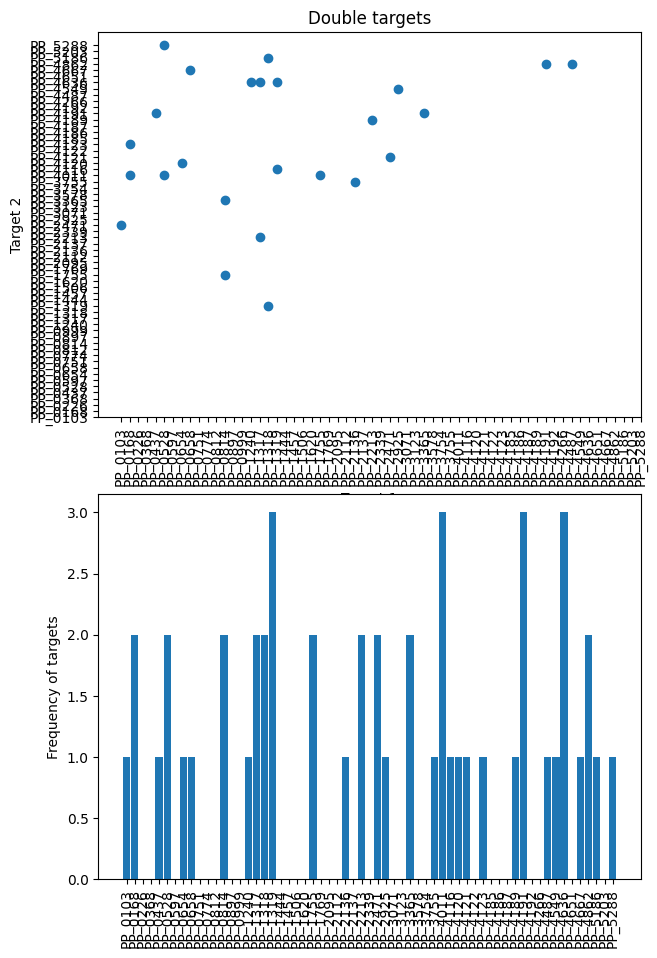

In [108]:
plot_double_targets(targets_double, df_targets2)


### Choose triple targets

As for the case of double targets, we choose triple targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

In [109]:
targets_triple = choose_targets(
    df_targets2, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
)

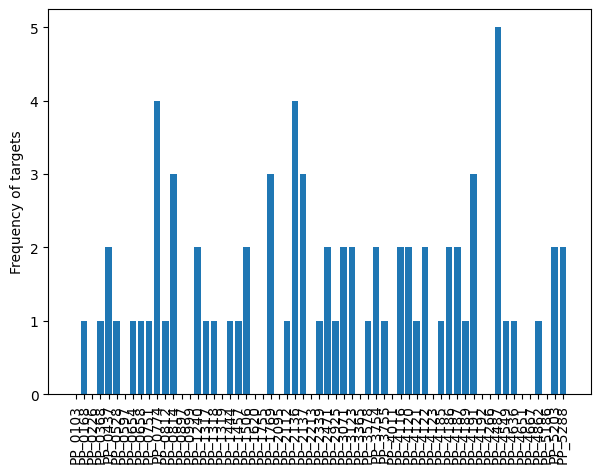

In [110]:
plot_triple_targets(targets_triple, df_targets2)

In [111]:
targets_triple

[('PP_0774', 'PP_2136', 'PP_4487'),
 ('PP_0437', 'PP_1769', 'PP_3578'),
 ('PP_0814', 'PP_2137', 'PP_4186'),
 ('PP_0528', 'PP_1240', 'PP_4122'),
 ('PP_0654', 'PP_4121', 'PP_4487'),
 ('PP_0774', 'PP_2137', 'PP_3754'),
 ('PP_2925', 'PP_4116', 'PP_5288'),
 ('PP_1769', 'PP_3071', 'PP_4122'),
 ('PP_1444', 'PP_2471', 'PP_3754'),
 ('PP_1506', 'PP_4120', 'PP_4187'),
 ('PP_3123', 'PP_4120', 'PP_4862'),
 ('PP_0751', 'PP_0814', 'PP_2137'),
 ('PP_2136', 'PP_4116', 'PP_4185'),
 ('PP_1457', 'PP_2136', 'PP_4186'),
 ('PP_1317', 'PP_1318', 'PP_5288'),
 ('PP_3755', 'PP_4191', 'PP_4636'),
 ('PP_1240', 'PP_1769', 'PP_4187'),
 ('PP_1506', 'PP_2136', 'PP_4549'),
 ('PP_0658', 'PP_3123', 'PP_4487'),
 ('PP_0168', 'PP_0774', 'PP_4191'),
 ('PP_3071', 'PP_4189', 'PP_5203'),
 ('PP_0774', 'PP_2471', 'PP_4487'),
 ('PP_2339', 'PP_4191', 'PP_4487'),
 ('PP_0812', 'PP_2112', 'PP_5203'),
 ('PP_0368', 'PP_0437', 'PP_0814')]

And we save them in a file:

In [112]:
with open(user_params['triple_targets_file'], mode="wt") as f:
    for target in targets_triple:
        f.write(str(target))